In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import random
from sklearn.manifold import MDS
from scipy.spatial.distance import jaccard, cosine, euclidean, correlation, cityblock
from scipy.sparse import random

import keras
from keras import layers

from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly.express as px
from plotly.offline import init_notebook_mode
from sklearn.metrics import pairwise_distances
from sklearn.metrics import euclidean_distances

from sklearn.metrics import r2_score


import plotly.io as pio
pio.renderers.default = "notebook_connected"

init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

# Problema de investigación: Clustering en extrema alta dimensionalidad
Como no se puede hacer clustering directo sobre un promedio de XXXX dimensiones para agrupar a los países por sector es necesario realizar previamente una reducción de la dimensionalidad.

Algunas de las herramientas existentes para la reducción de dimensionalidad:
* PCA
* t-SNE
* UMAP

Sus límites implican buscar alternativas que puedan enfrentar eficientemente el problema, tanto desde el punto de vista de la  exactitud de sus resultados (dificil de evaluar en una clasificación no supervisada) como desde el punto de vista computacional (que pueda ejecutarse y obtener resultados en un tiempo prudencial).

Una aproximación posible a este problema es la utilización de Autoencoders, redes neuronales cuyo propósito es la reducción de la dimensionalidad abstrayendo atributos de datos complejos a través de diferentes capas de procesamiento.

In [2]:
raw_data = pd.read_csv(r"C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\BACI_HS17_Y2019_V202301.csv")
codigos = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\BACI_HS17_V202301\country_codes_V202301.csv')
GDP_L = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\GDP_L.csv')
region = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\region.csv')
population = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\population.csv')

ncm_ciiu = pd.read_csv(r'C:\Users\igalk\OneDrive\Documentos\laburo\promo_exportacion\BBDD\hs5_isic3.csv',
                                                    dtype={"HS5_6d":str,
                                                          "HS5_4d":str,
                                                          "HS5_2d":str,
                                                          "ISIC3_4d":str,
                                                          "ISIC3_3d":str,
                                                          "ISIC3_2d":str,
                                                          "ISIC3_1d":str})

In [3]:
raw_data.rename(columns={"k": "hs17_6d", "i": "x", "j": "m"}, inplace=True)
raw_data.drop(columns=["t", "m", "q"], inplace=True)
raw_data['hs17_6d'] = raw_data['hs17_6d'].astype(str)
raw_data['hs17_6d'] = raw_data['hs17_6d'].apply(lambda x: x.zfill(6) if len(x) == 5 else x)
raw_data = raw_data.groupby(['x','hs17_6d'], as_index=False)['v'].sum()

#raw_data["hs17_2d"] = raw_data['hs17_6d'].str[:2]

raw_data = raw_data.merge(codigos[["iso_3digit_alpha", 'country_code']], left_on='x', right_on='country_code',
                          how='left').drop(columns=['country_code', 'x']).rename(columns={"iso_3digit_alpha": "x"})

raw_data = pd.merge(raw_data, ncm_ciiu[['HS5_6d','ISIC3_2d']], left_on="hs17_6d", right_on="HS5_6d", how="left").drop(columns="HS5_6d").dropna()

In [4]:

raw_data = pd.merge(raw_data, population[['Country Code','2019']], left_on="x", right_on="Country Code", how="left").rename(columns={'2019': 'population'})

raw_data= raw_data[raw_data.population>1000000]



In [5]:
raw_data = raw_data.drop(columns='population')

In [6]:
raw_data["v_rel"] = raw_data['v'] / raw_data.groupby(['x', 'ISIC3_2d'])['v'].transform('sum')


In [7]:
dimensionalidad = raw_data[['ISIC3_2d','hs17_6d']].drop_duplicates().groupby(['ISIC3_2d'], as_index=False)['hs17_6d'].count()
display(dimensionalidad[dimensionalidad.index<=29])

,ISIC3_2d,hs17_6d
0,01,294
1,02,39
2,05,72
3,10,7
4,11,4
5,12,2
6,13,21
7,14,66
8,15,560
9,16,7


In [8]:
## Grafo

# distancia = pairwise_distances(sector_binary.values, metric='jaccard')
#
# distancia[np.triu_indices(distancia.shape[0], k=0)] = np.nan
# distancia = pd.DataFrame(distancia, index=sector.index, columns=sector.index)
# distancia = distancia.unstack()
# distancia.index.names = ['c1', 'c2']
# distancia = distancia.reset_index().rename(columns={0: 'inv_weight'})
# data_network = distancia[pd.notna(distancia.inv_weight)]
# data_network['weight'] = 1-data_network.inv_weight
#
#
# data_network[['c1', 'c2', 'weight']]

In [9]:
# import networkx as nx
# plt.figure(figsize=(15,15))
#
# G = nx.from_pandas_edgelist(data_network, 'c1', 'c2', edge_attr=['weight'])
#
# T = nx.minimum_spanning_tree(G, weight='inv_weight')
#
# threshold = 0
# for node in G.nodes():
#     if G.degree(node) > threshold:
#         T.add_node(node)
#
# pos = nx.spring_layout(T)
#
# nx.draw_networkx(G,
#                  pos,
#                  with_labels=True, node_size=100)
#
#
# plt.show()

In [10]:
# communities = nx.community.louvain_communities(T, seed=46)

In [11]:
# num_communities = len(communities)
# num_communities

In [12]:
# communities

In [13]:
# node_community_dict = {}
# for community_id, community in enumerate(communities):
#     for node in community:
#         node_community_dict[node] = community_id

In [14]:
# color_map = plt.get_cmap('tab20', num_communities)
#
# # Step 5: Create a list of colors for each node based on their community assignment
# node_colors = [color_map(node_community_dict[node]) for node in G.nodes()]
#


otro intento

In [15]:
def recorte_sectorial(ciiu, raw_data=raw_data):
    data = raw_data.copy()
    sector = data[data.ISIC3_2d==ciiu]
    sector = pd.pivot_table(sector, index='x', columns='hs17_6d', values='v_rel').fillna(0)
    sector_binary = pd.DataFrame(np.where(sector>0.01, 1, 0), index=sector.index, columns=sector.columns)
    return sector_binary

In [16]:
def distancia(sector_binary):
    distancia= pairwise_distances(sector_binary.values, metric='jaccard')
    dist_matrix = pd.DataFrame(distancia, index=sector_binary.index, columns=sector_binary.index)
    return dist_matrix


In [17]:


def dimensionality_reduction(dist_matrix):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, metric=True)
    embedding = mds.fit_transform(dist_matrix)
    #print(f"absolut stress: {mds.stress_}")
    dissimilarity_matrix_reconstructed = euclidean_distances(embedding, embedding)
    dissimilarity_matrix_reconstructed[np.triu_indices(dissimilarity_matrix_reconstructed.shape[0], k=1)] = np.nan

    np_dist_matrix = np.array(dist_matrix)
    np_dist_matrix[np.triu_indices(np_dist_matrix.shape[0], k=1)] = np.nan

    errores = (np_dist_matrix - dissimilarity_matrix_reconstructed).flatten()
    errores = errores[~np.isnan(errores)]

    ## Visualizacion de errores
    sns.histplot(errores, bins=10)
    plt.axvline(np.mean(errores), color='red')
    plt.axvline(np.median(errores), color='green')
    #plt.show()


    ### R2 ####
    d_true = (np_dist_matrix).flatten()
    d_true = d_true[~np.isnan(d_true)]
    #print(y_train.shape)
    d_pred = (dissimilarity_matrix_reconstructed).flatten()
    d_pred = d_pred[~np.isnan(d_pred)]
    #print(y_pred.shape)
    print('R2:', r2_score(d_true,d_pred))


    ############

    numerador= np.nansum((np_dist_matrix - dissimilarity_matrix_reconstructed)**2)

    ### denominador, distancias al cuadrado

    denominador = np.nansum(dissimilarity_matrix_reconstructed**2) # se usa para normalizar el stress en NMDS (ordinal)

    root_stress = np.sqrt(numerador/denominador)

    print(f"root stress: {root_stress}")


    ### Promedio simple de los errores ###

    denominador=np_dist_matrix.copy()
    denominador[np.tril_indices(denominador.shape[0], k=1)] = 1
    denominador = np.nansum(denominador)

    mean_stress = numerador/denominador
    print(f"mean stress: {mean_stress}")

    ### varianza de los errores
    print(f'Varianza del desvio del error: {np.var(errores)}')

    # pd.DataFrame(embedding).plot.scatter(x=0, y=1, title=ciiu)
    # plt.show()
    return embedding

In [18]:
def k_means(new_coord):
    k_range = range(2, 11)

    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123).fit(new_coord)
        labels = kmeans.labels_
        score = silhouette_score(new_coord, labels)
        silhouette_scores.append(score)

    # Plot the average silhouette score for each value of k
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average silhouette score')
    #plt.show()

    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

    kmeans = KMeans(n_clusters=optimal_k)
    clusters = kmeans.fit_predict(new_coord)
    return clusters

In [19]:

def plot_clusters(new_coord, clusters):#, sector_xx_pivot):

    sns.scatterplot(data=new_coord,
                 x=new_coord[:, 0],
                 y=new_coord[:, 1],
                 hue=clusters,
                 palette="YlGnBu",
                   )

    return

Análisis del sector 01:
R2: -6.764227758332211
root stress: 0.41081246009224115
mean stress: 0.12499148791304299
Varianza del desvio del error: 0.10550135403317683


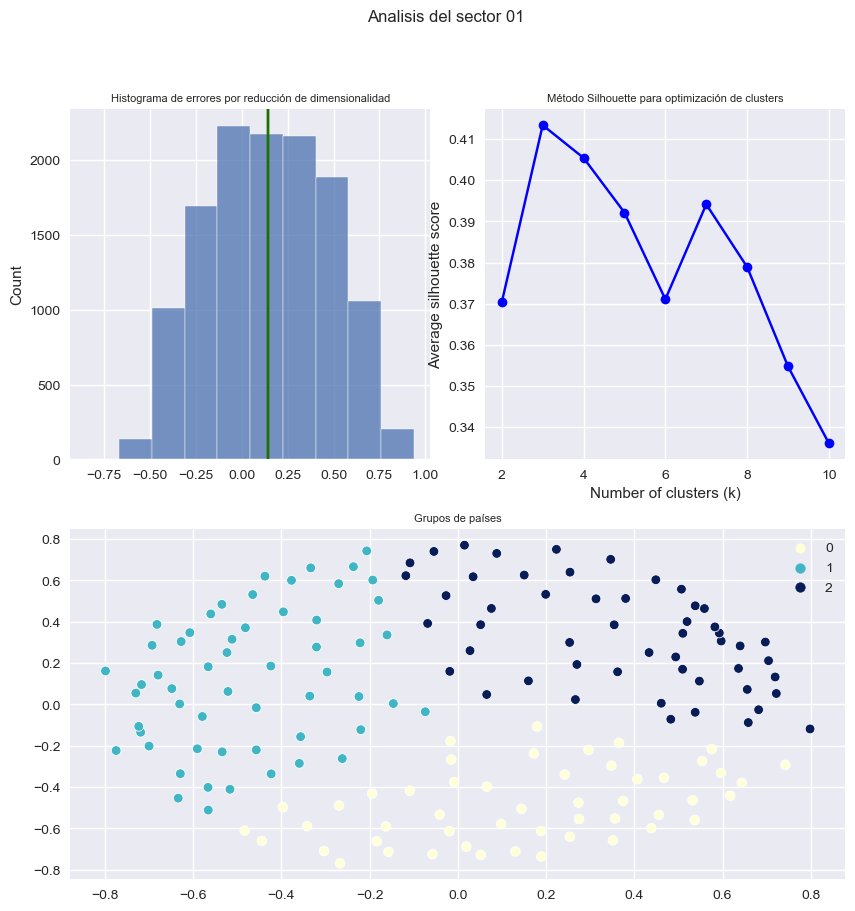

Análisis del sector 02:
R2: -1.4308308665668399
root stress: 0.35134746565435704
mean stress: 0.07801014176441586
Varianza del desvio del error: 0.06735102706110263


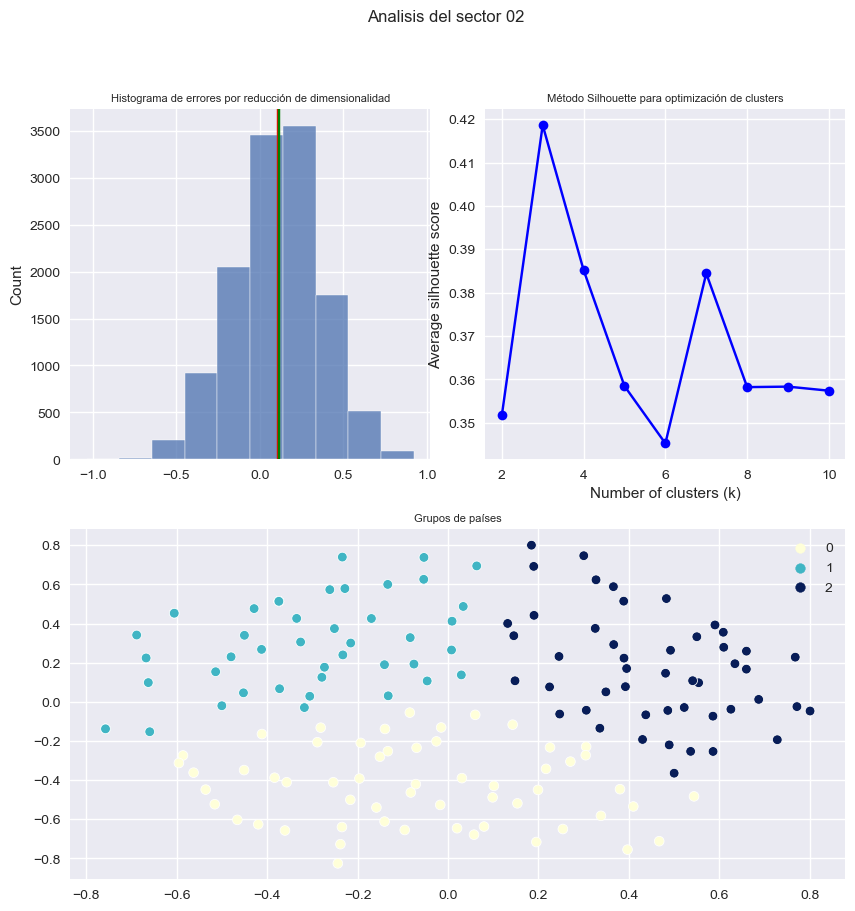

Análisis del sector 05:
R2: -4.351254419789641
root stress: 0.3986652061624857
mean stress: 0.11098902718682996
Varianza del desvio del error: 0.09426573208268385


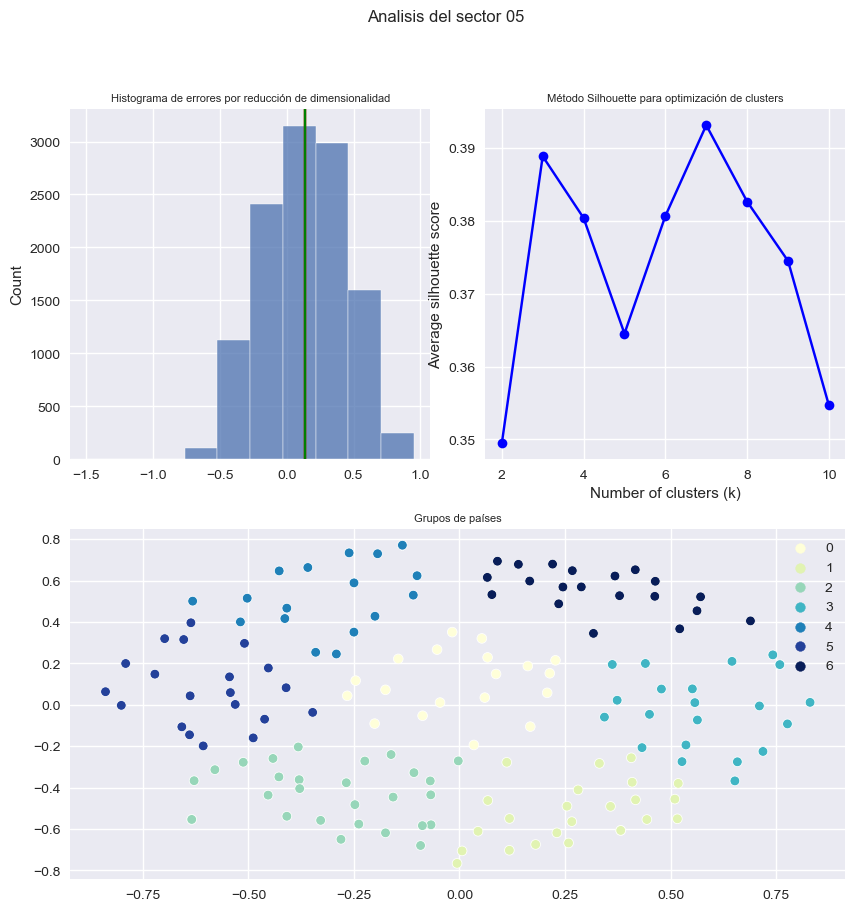

Análisis del sector 10:
R2: 0.5793811200250807
root stress: 0.24872603565854723
mean stress: 0.029374772257567284
Varianza del desvio del error: 0.027508429283139735


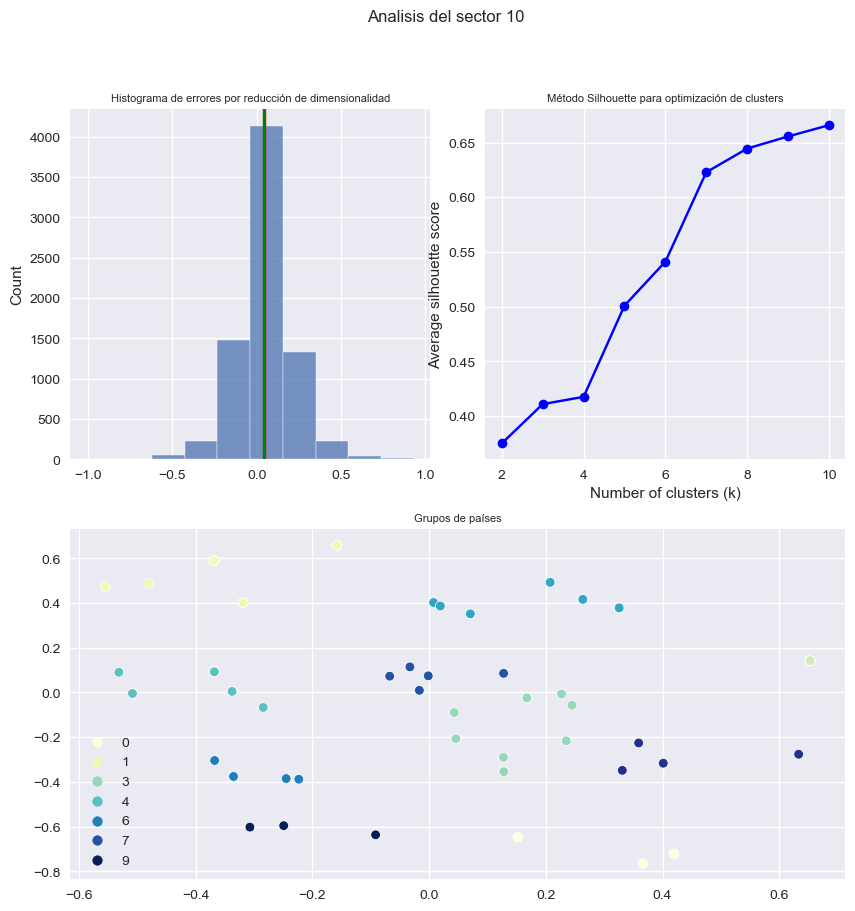

Análisis del sector 11:
R2: 0.9539121701001021
root stress: 0.11474404958314298
mean stress: 0.004288365699252868
Varianza del desvio del error: 0.004326113187948975


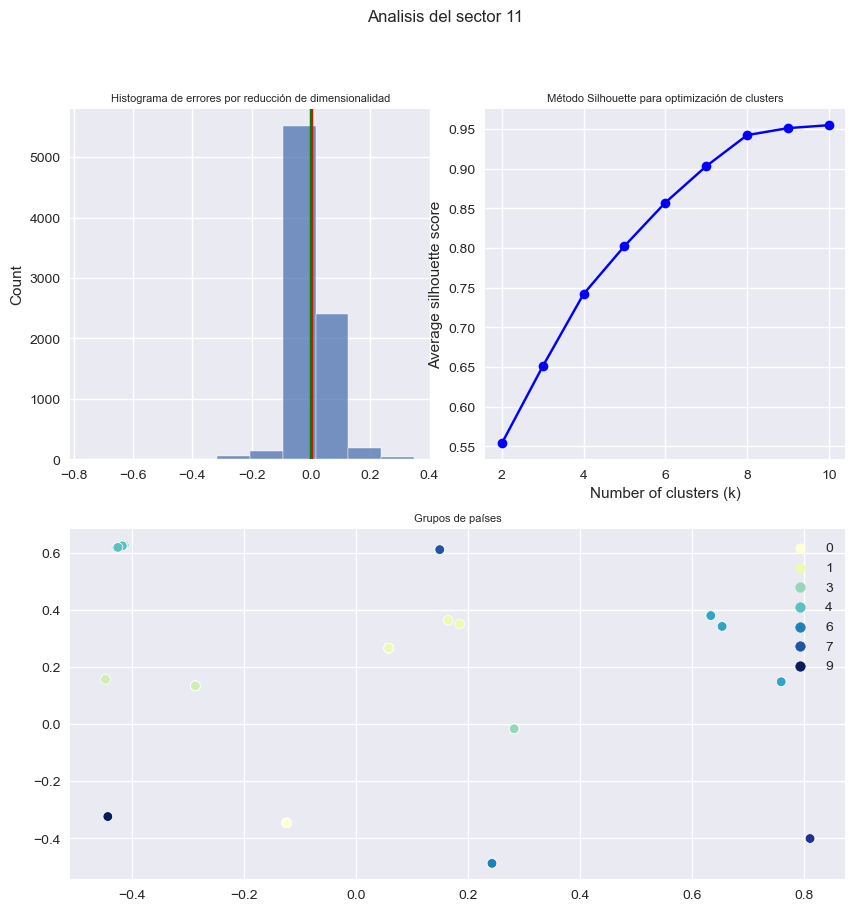

Análisis del sector 12:
R2: 0.9998898101967949
root stress: 0.007650016878345952
mean stress: 2.1120066946756096e-05
Varianza del desvio del error: 2.1698921714447182e-05


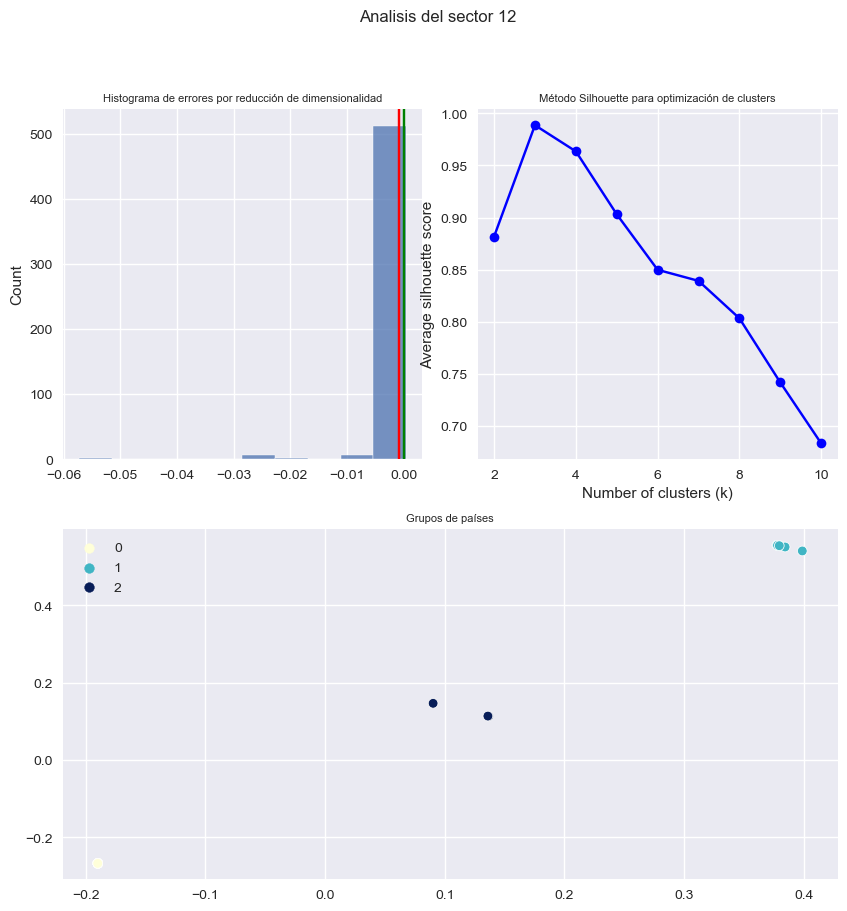

Análisis del sector 13:
R2: -1.7162327573188056
root stress: 0.36991261234091616
mean stress: 0.09116199589664087
Varianza del desvio del error: 0.0789145928722081


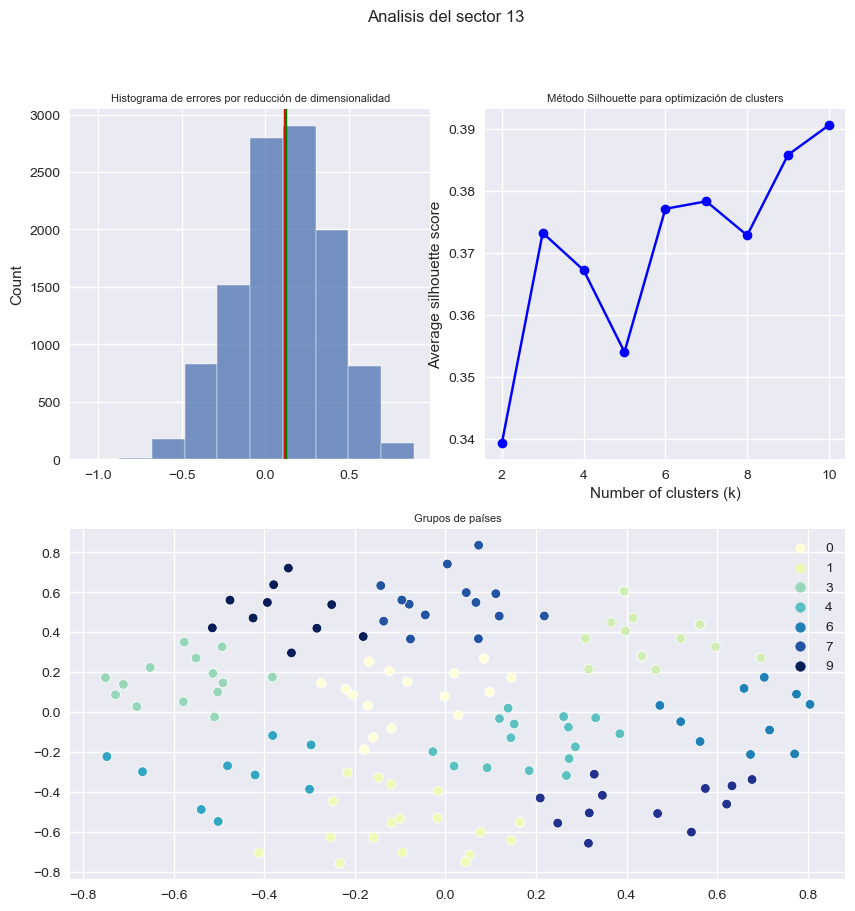

Análisis del sector 14:
R2: -3.972469415874712
root stress: 0.3976507736017094
mean stress: 0.10641860414076387
Varianza del desvio del error: 0.0903958844255474


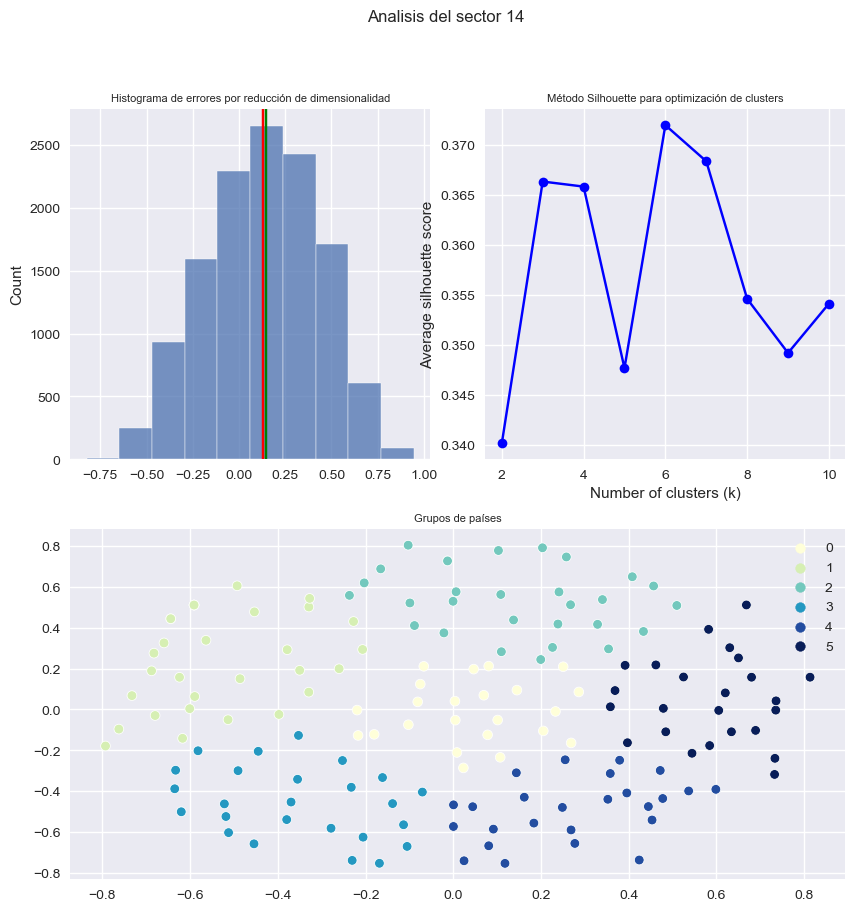

Análisis del sector 15:
R2: -7.544758764639074
root stress: 0.4221566471952691
mean stress: 0.1293691286976136
Varianza del desvio del error: 0.10904353949421998


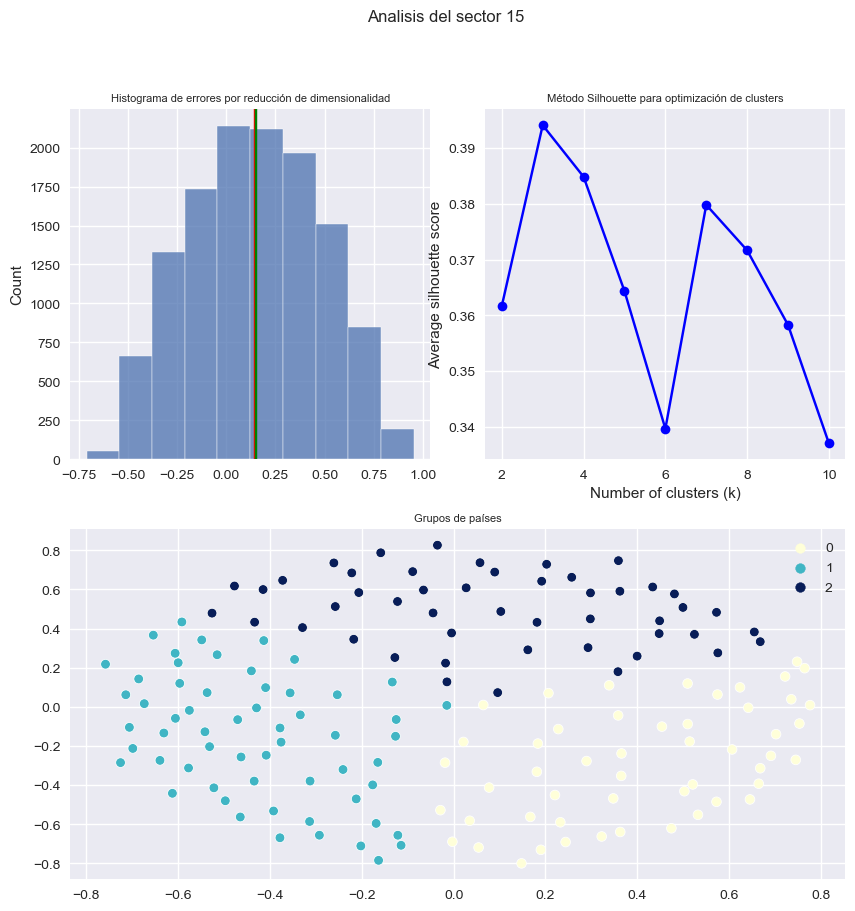

Análisis del sector 16:
R2: 0.552944692711729
root stress: 0.26082203803105036
mean stress: 0.026700621285322215
Varianza del desvio del error: 0.024973339829549596


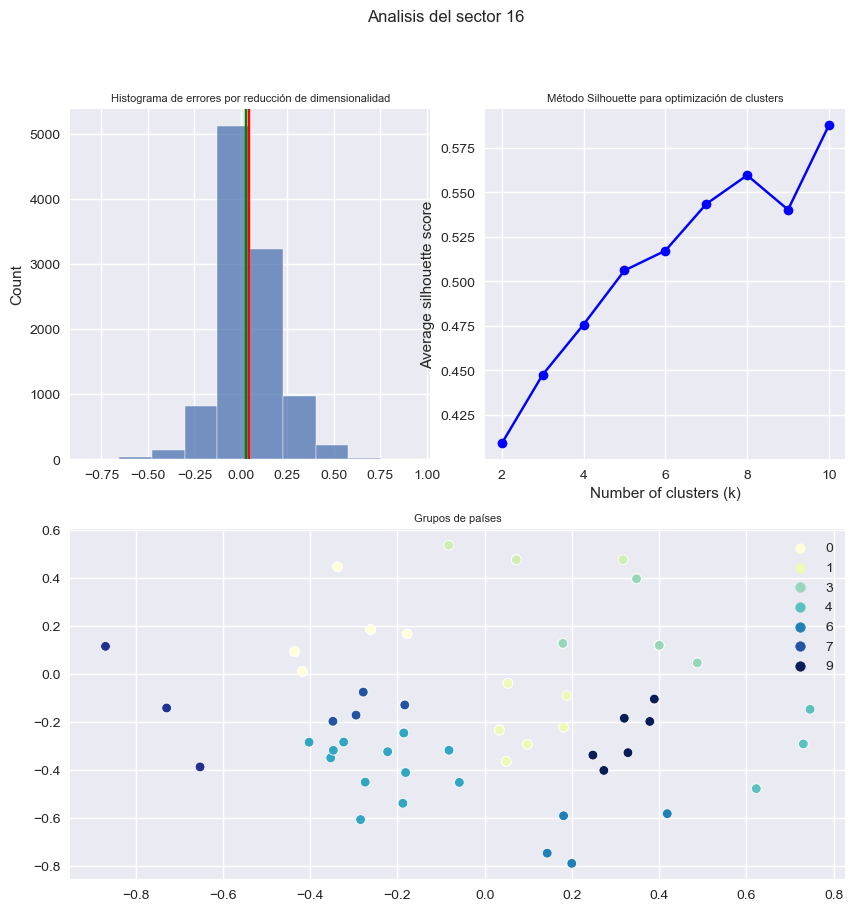

Análisis del sector 17:
R2: -5.107867174332629
root stress: 0.40714920744064975
mean stress: 0.11221481128328643
Varianza del desvio del error: 0.09473588305156172


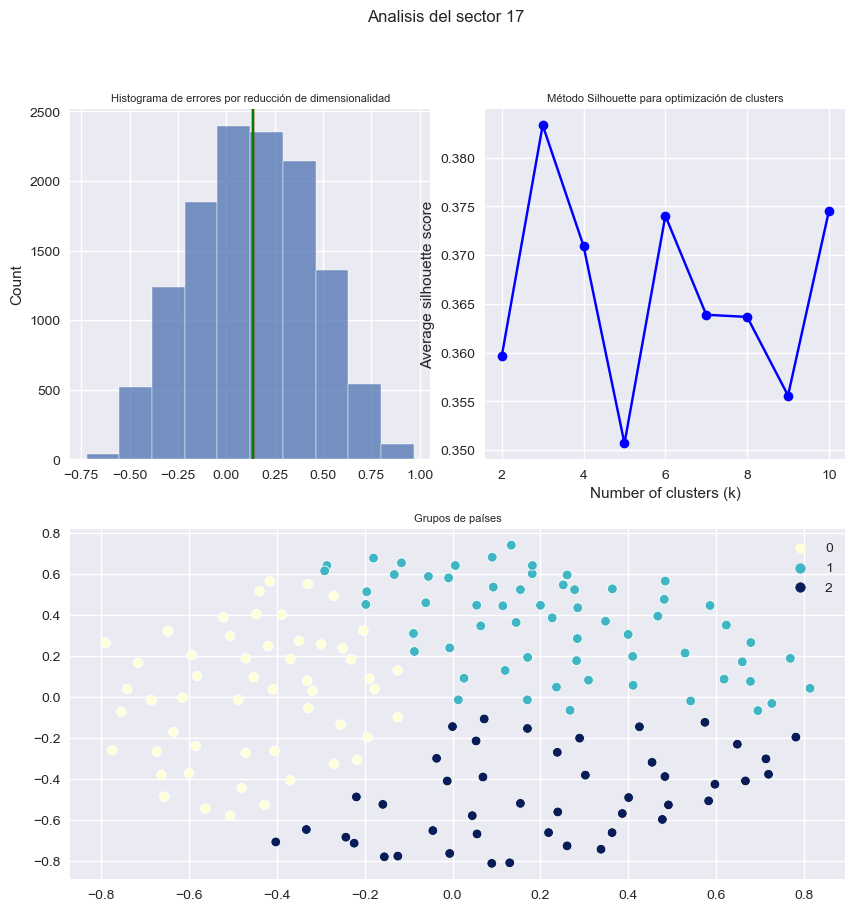

Análisis del sector 18:
R2: -3.261411394852492
root stress: 0.3841856108669329
mean stress: 0.09201606537997552
Varianza del desvio del error: 0.07798153471656273


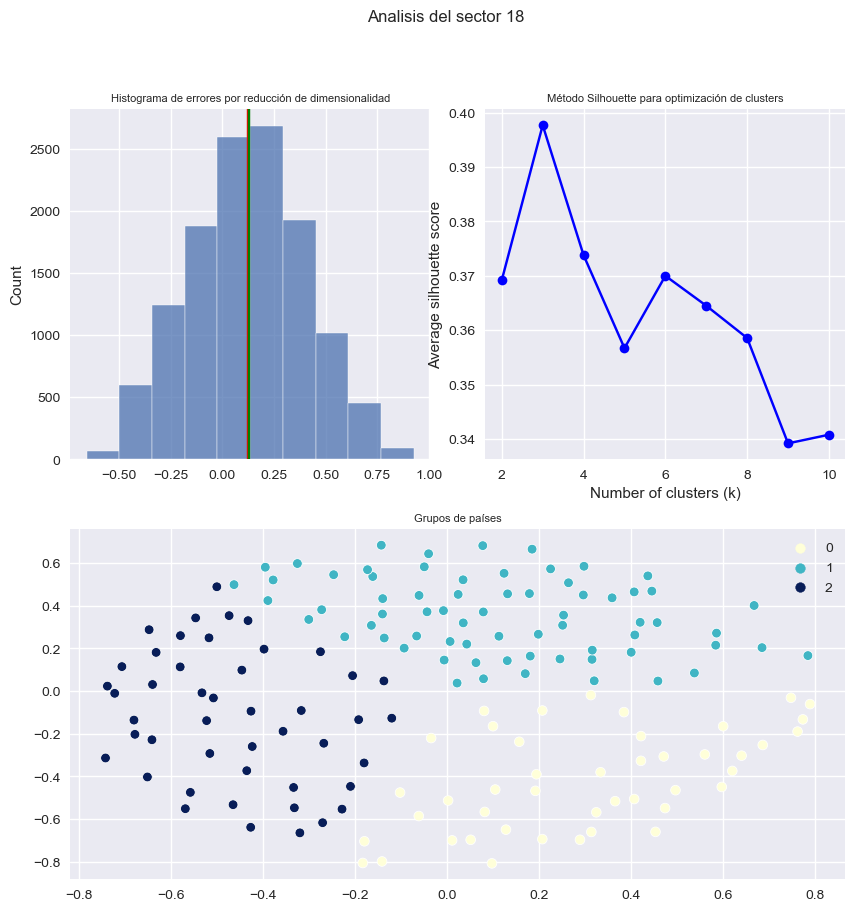

Análisis del sector 19:
R2: -1.3342854161321882
root stress: 0.35092741283678663
mean stress: 0.069732234384881
Varianza del desvio del error: 0.05943690175229078


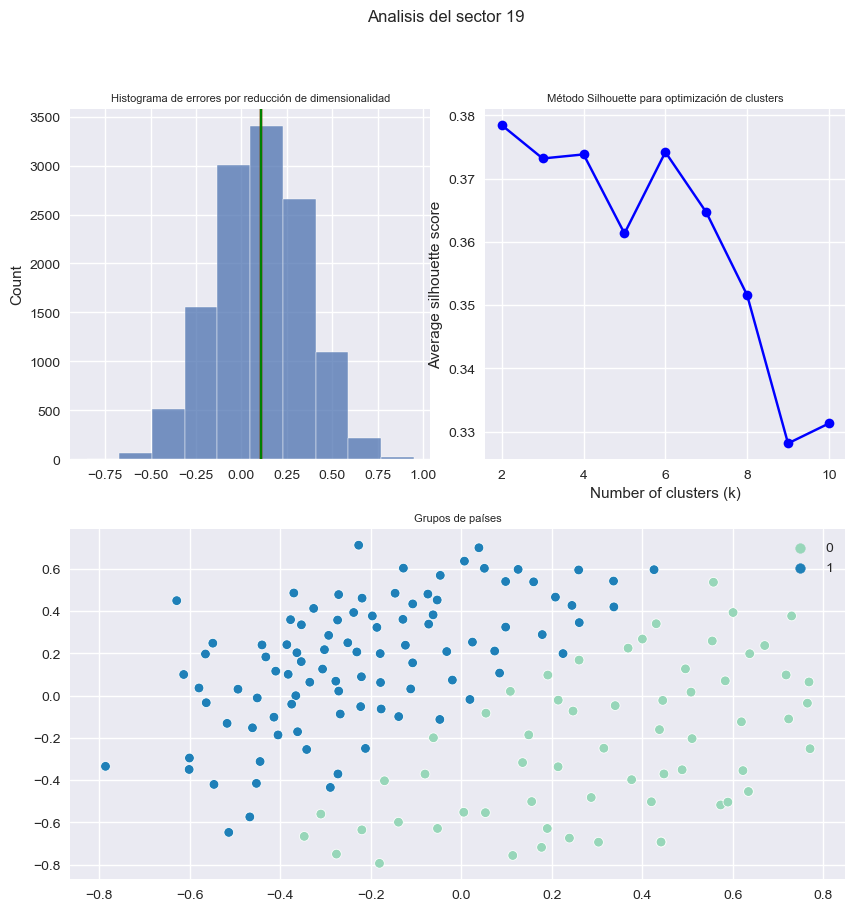

Análisis del sector 20:
R2: -2.6928686957277304
root stress: 0.3693317533587
mean stress: 0.08500281417120024
Varianza del desvio del error: 0.0721895001267448


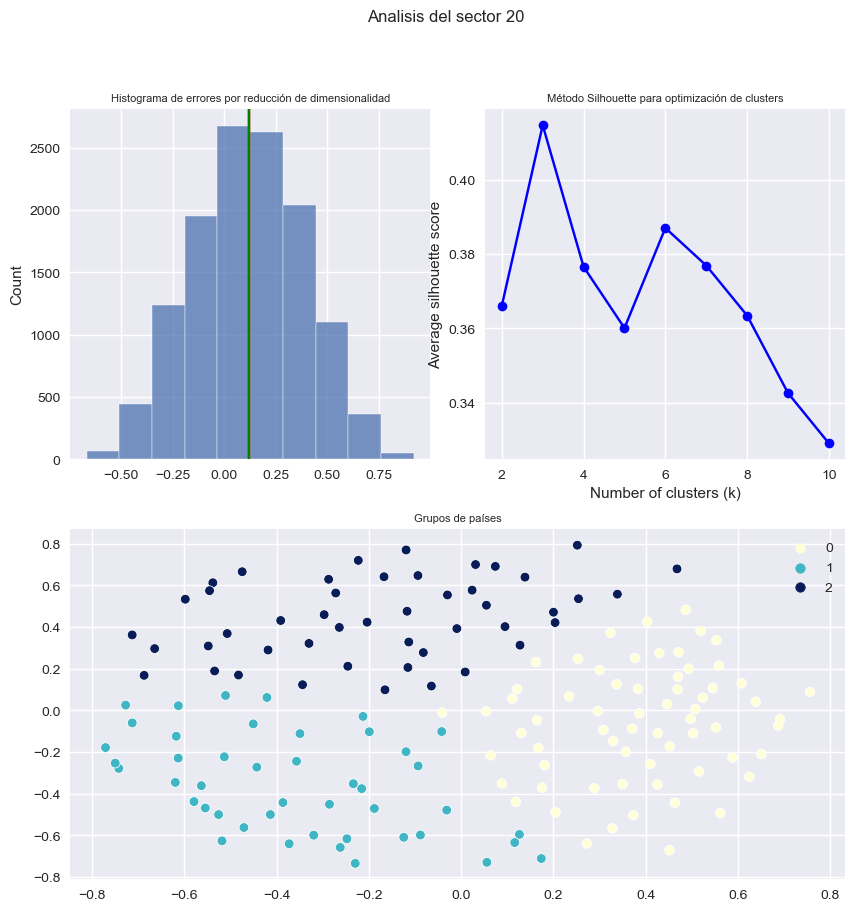

Análisis del sector 21:
R2: -3.0159401567461517
root stress: 0.3854800830000858
mean stress: 0.08809512381460409
Varianza del desvio del error: 0.07471211842307492


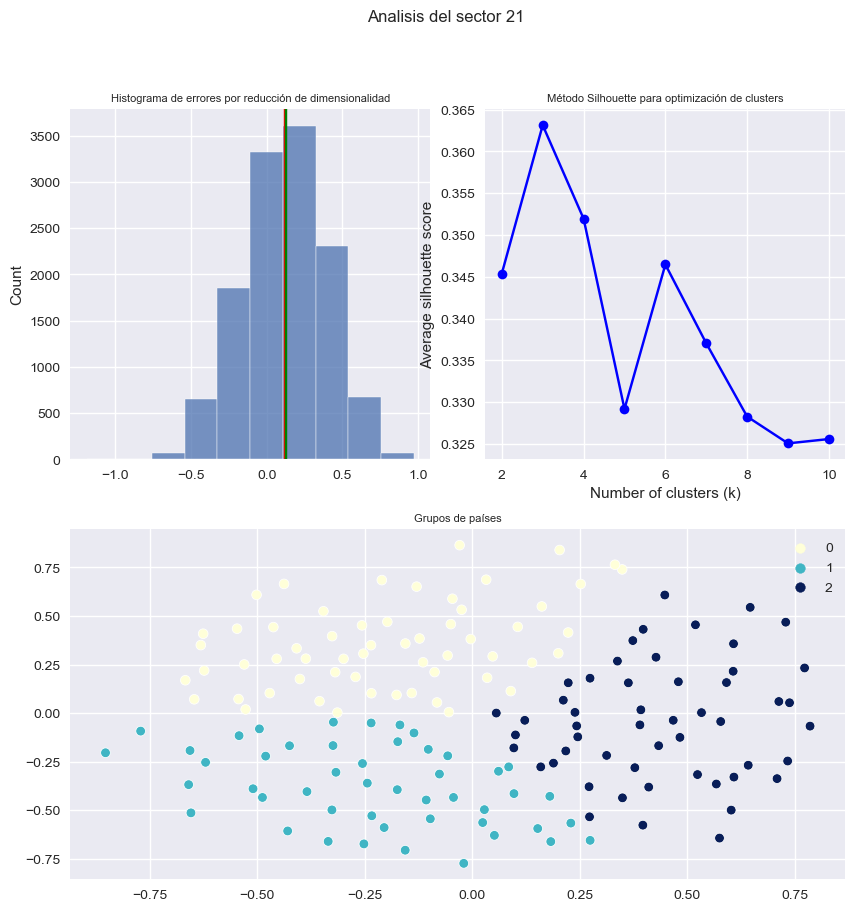

Análisis del sector 22:
R2: -0.30965020587584724
root stress: 0.3295882291429338
mean stress: 0.04484373234057335
Varianza del desvio del error: 0.038900243919670154


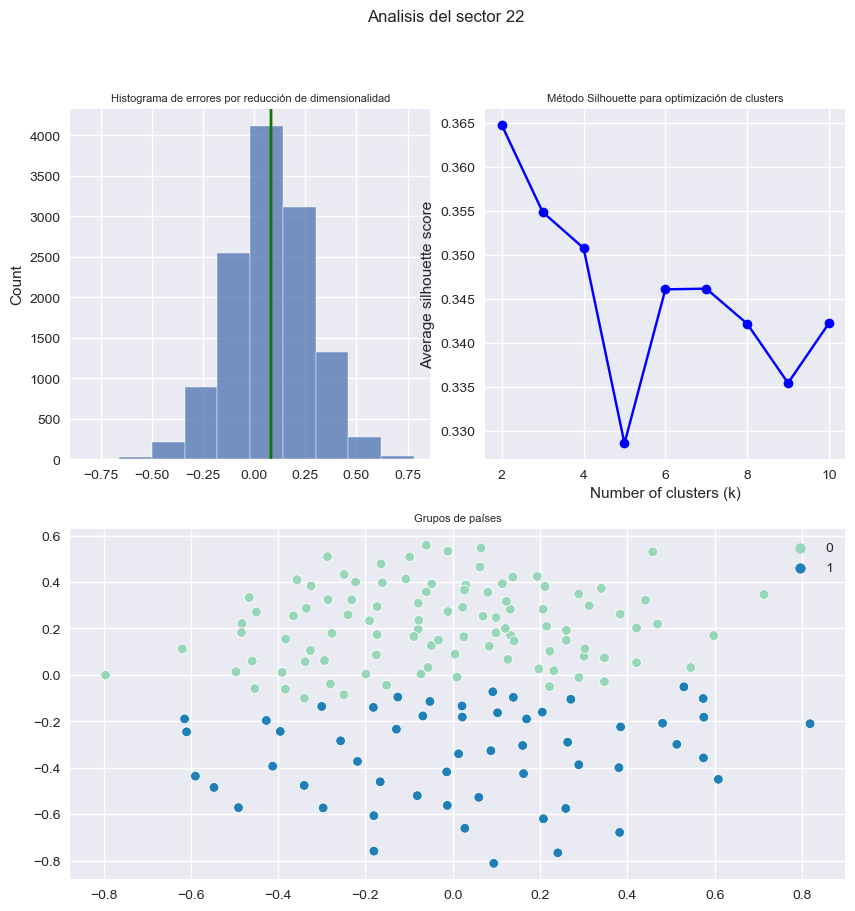

Análisis del sector 23:
R2: -0.39009724040083515
root stress: 0.3243432468542063
mean stress: 0.05926984410002524
Varianza del desvio del error: 0.05193316226922256


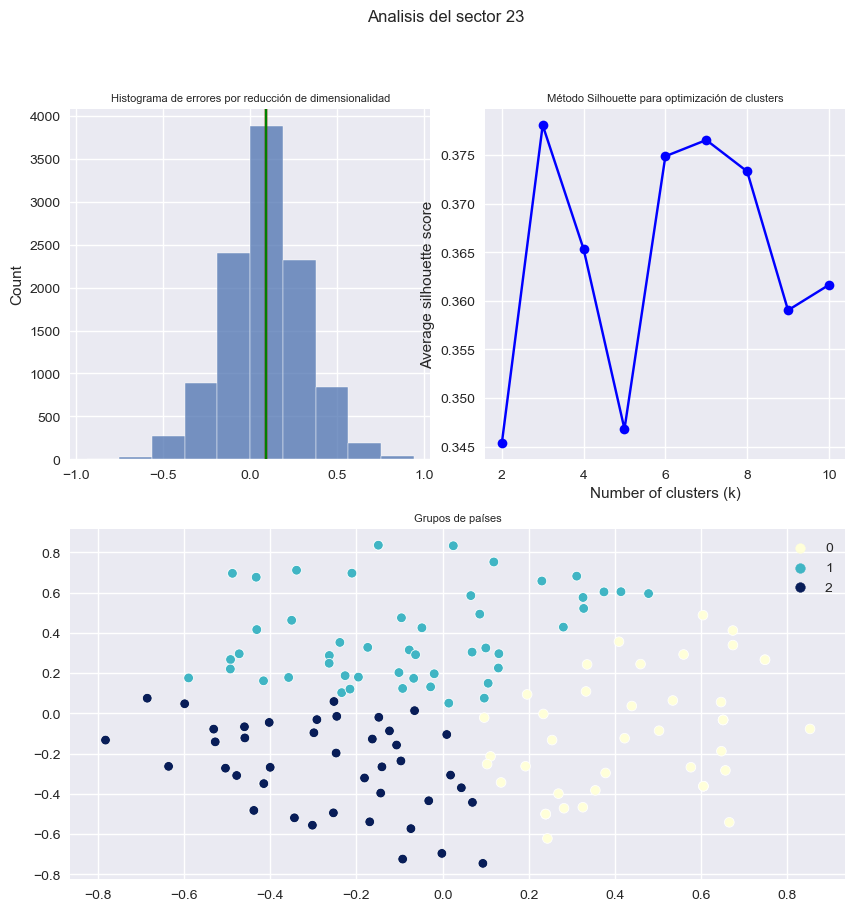

Análisis del sector 24:
R2: -8.316654989467072
root stress: 0.4287585613091011
mean stress: 0.1316226994120862
Varianza del desvio del error: 0.1108793963209046


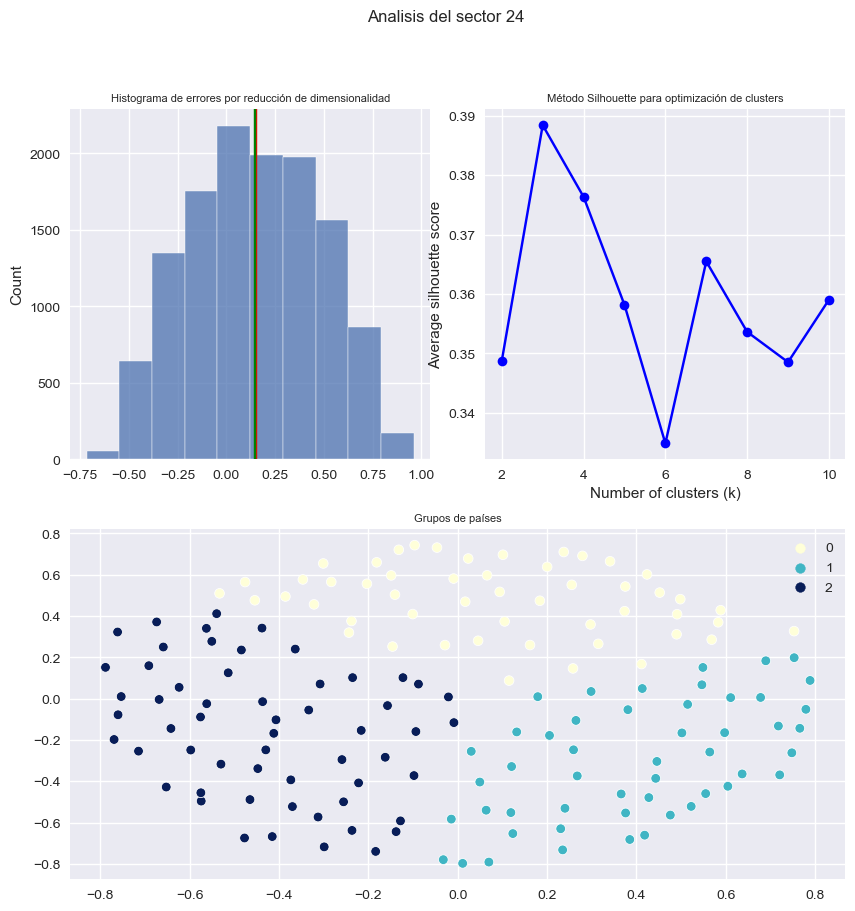

Análisis del sector 25:
R2: -2.598874891591867
root stress: 0.3809467412933757
mean stress: 0.07281682713785144
Varianza del desvio del error: 0.061915761587089


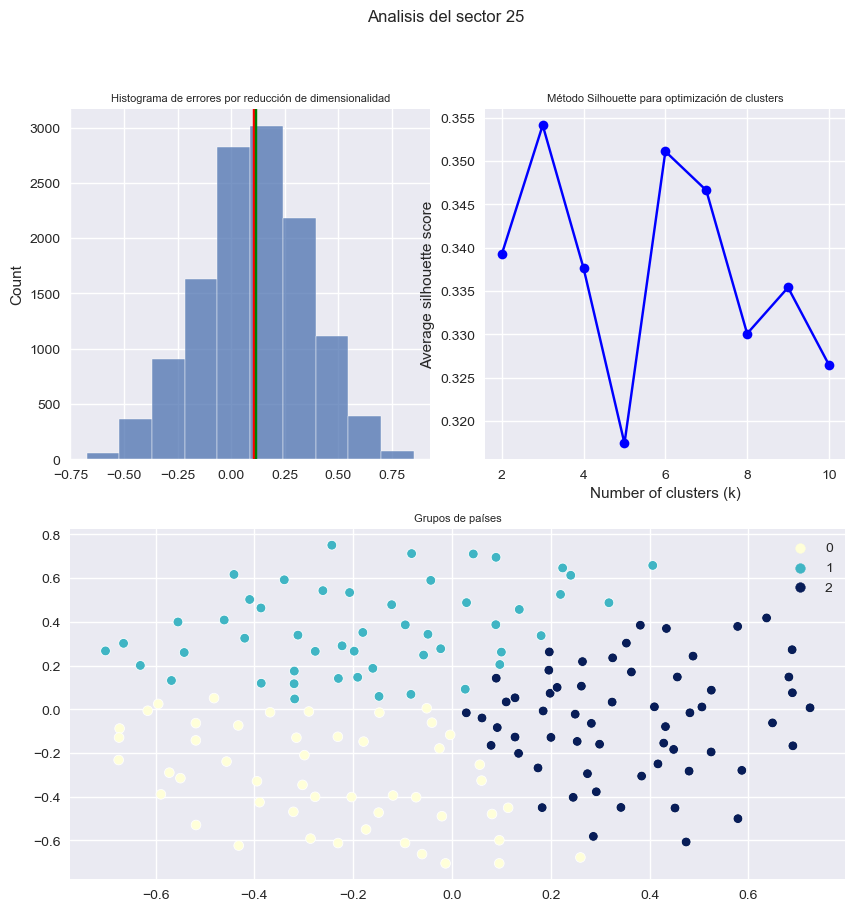

Análisis del sector 26:
R2: -6.193212221780057
root stress: 0.40973095632857043
mean stress: 0.11445618142265869
Varianza del desvio del error: 0.09662795827917463


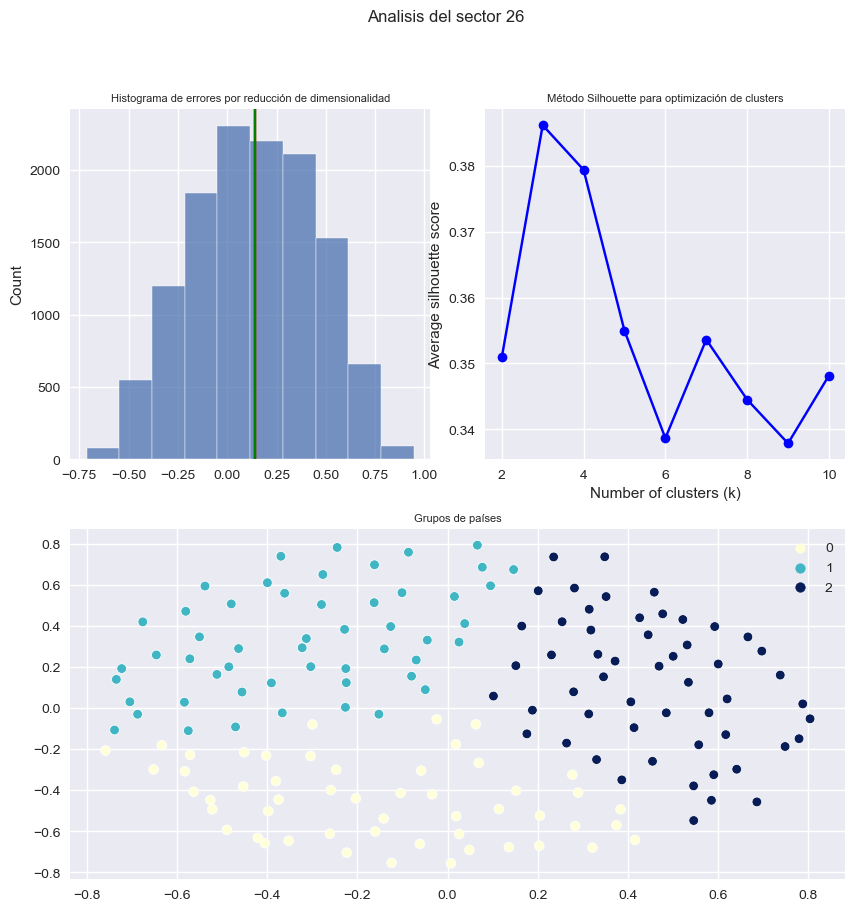

Análisis del sector 27:
R2: -3.0568526366726188
root stress: 0.38529592025990994
mean stress: 0.10110141941228099
Varianza del desvio del error: 0.08619332605457171


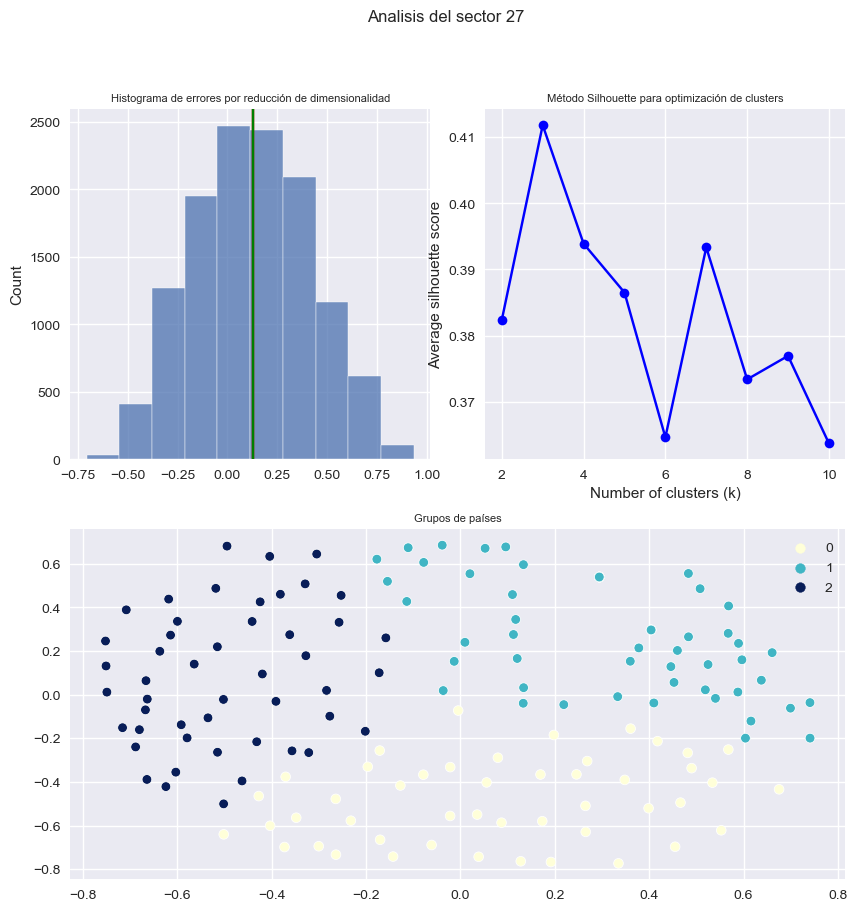

Análisis del sector 28:
R2: -4.598309113735547
root stress: 0.40247028442955507
mean stress: 0.09404596296242841
Varianza del desvio del error: 0.07950261221817731


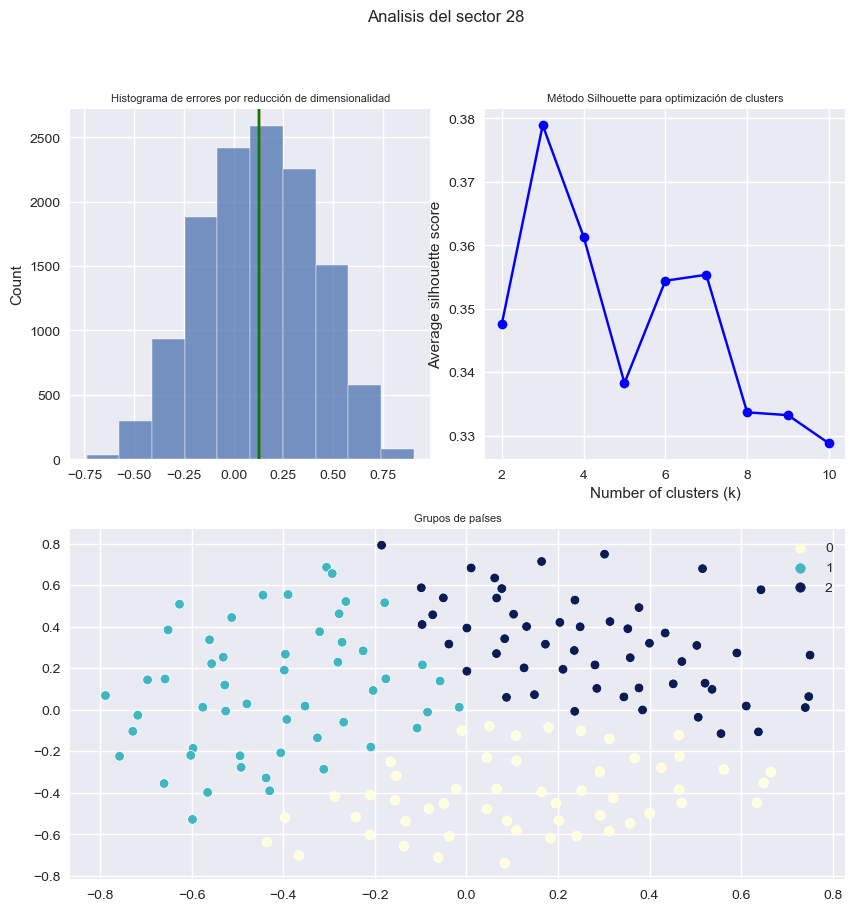

Análisis del sector 29:
R2: -6.976085479794533
root stress: 0.4164217756532937
mean stress: 0.11635644931708845
Varianza del desvio del error: 0.09807385279925362


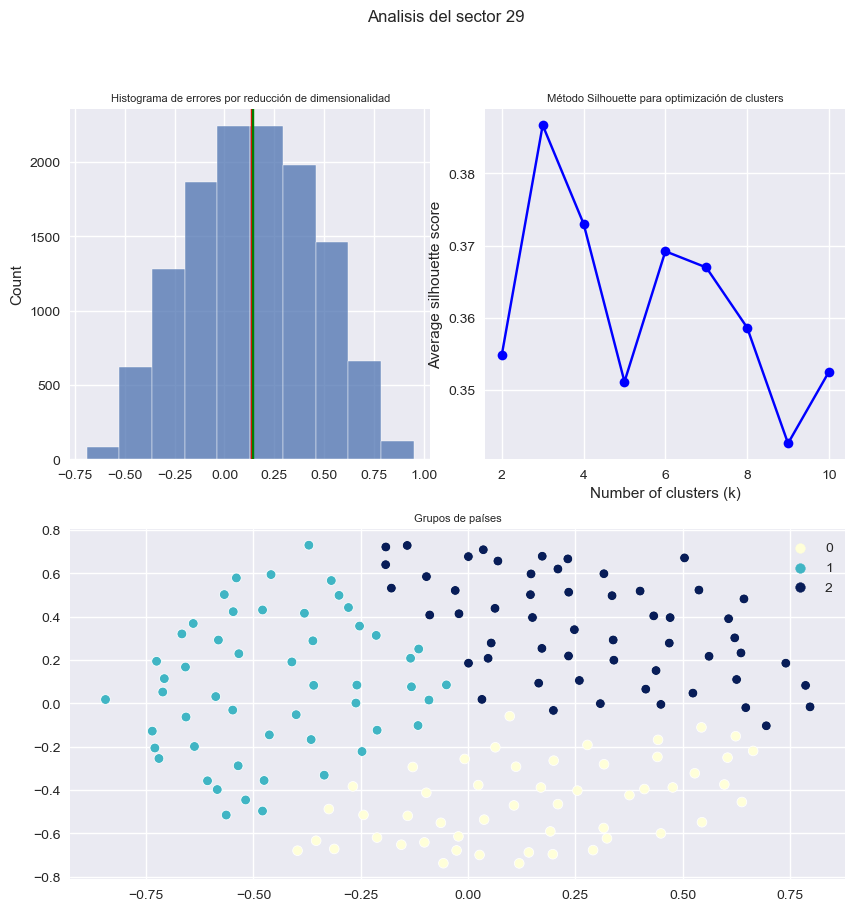

Análisis del sector 30:
R2: 0.29076325373730016
root stress: 0.29808955612517485
mean stress: 0.02450212825903511
Varianza del desvio del error: 0.021753742795702358


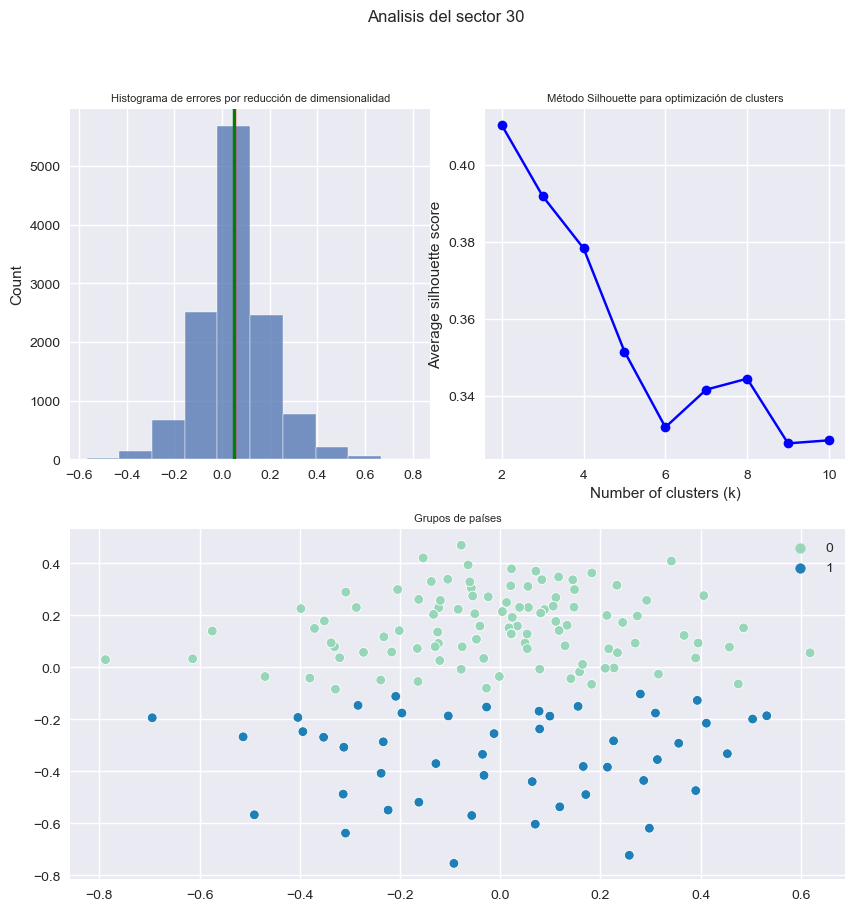

Análisis del sector 31:
R2: -2.9183573915048098
root stress: 0.3815568531552367
mean stress: 0.08411796889856642
Varianza del desvio del error: 0.07133188287925134


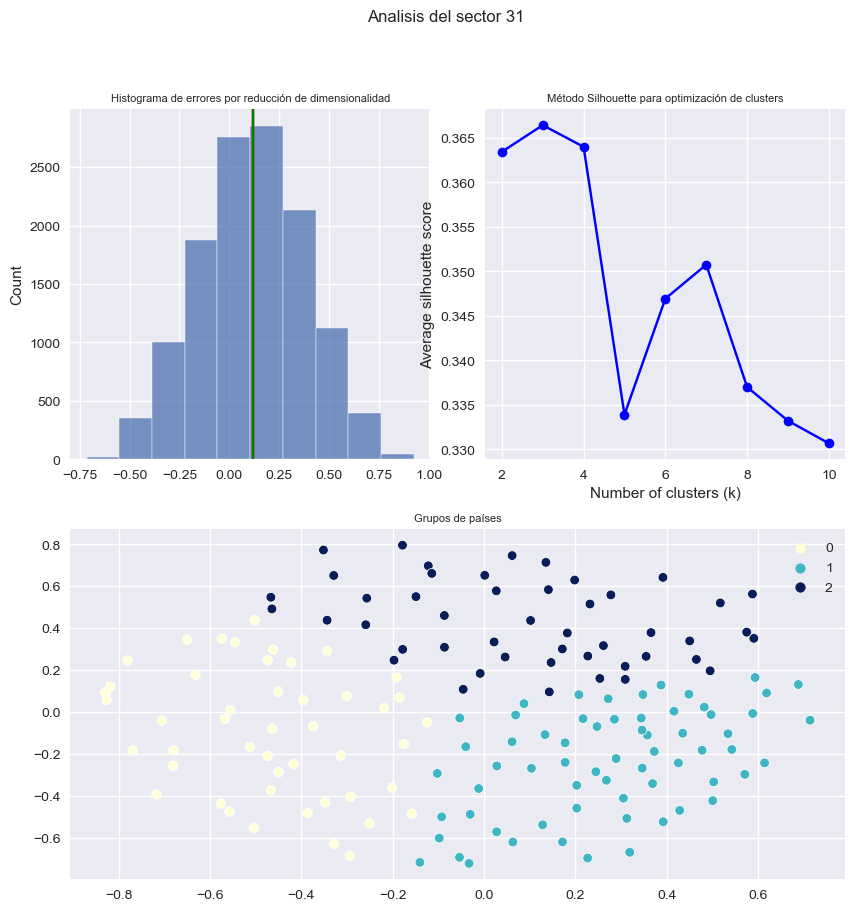

Análisis del sector 32:
R2: -2.1181403436380584
root stress: 0.3748095555334233
mean stress: 0.0680445434347233
Varianza del desvio del error: 0.05799547647327641


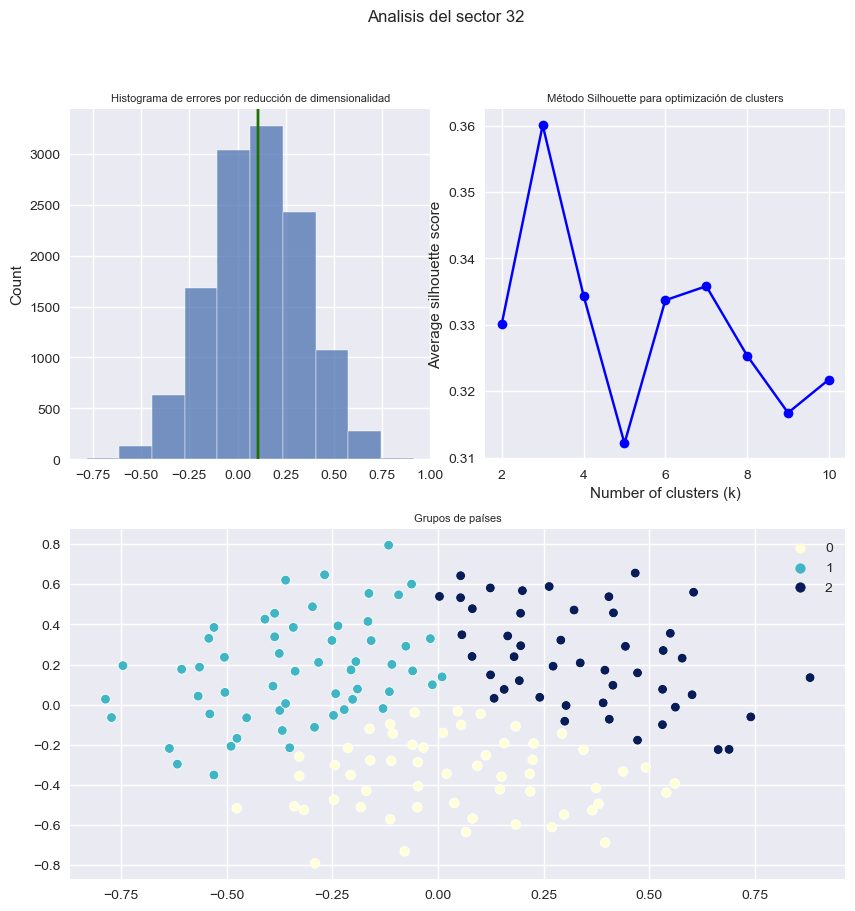

Análisis del sector 33:
R2: -5.063483316923404
root stress: 0.4014550952508623
mean stress: 0.09620299333279347
Varianza del desvio del error: 0.08130135212713548


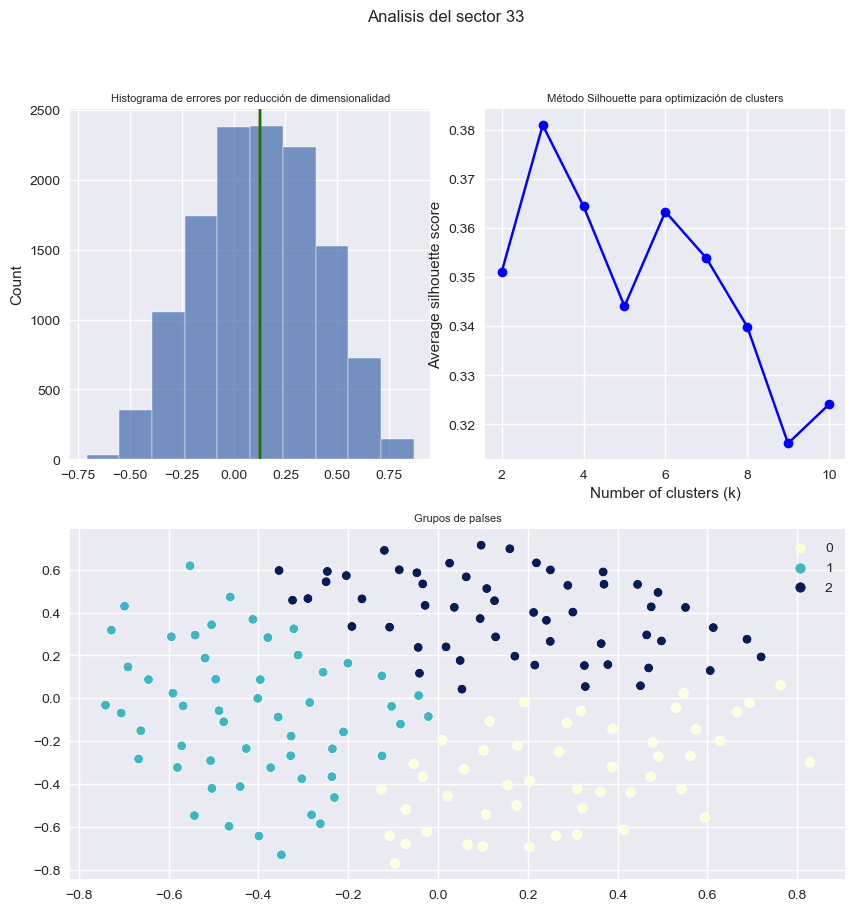

Análisis del sector 34:
R2: -1.79171615337459
root stress: 0.3574287490726087
mean stress: 0.06023830663390106
Varianza del desvio del error: 0.05140032370586686


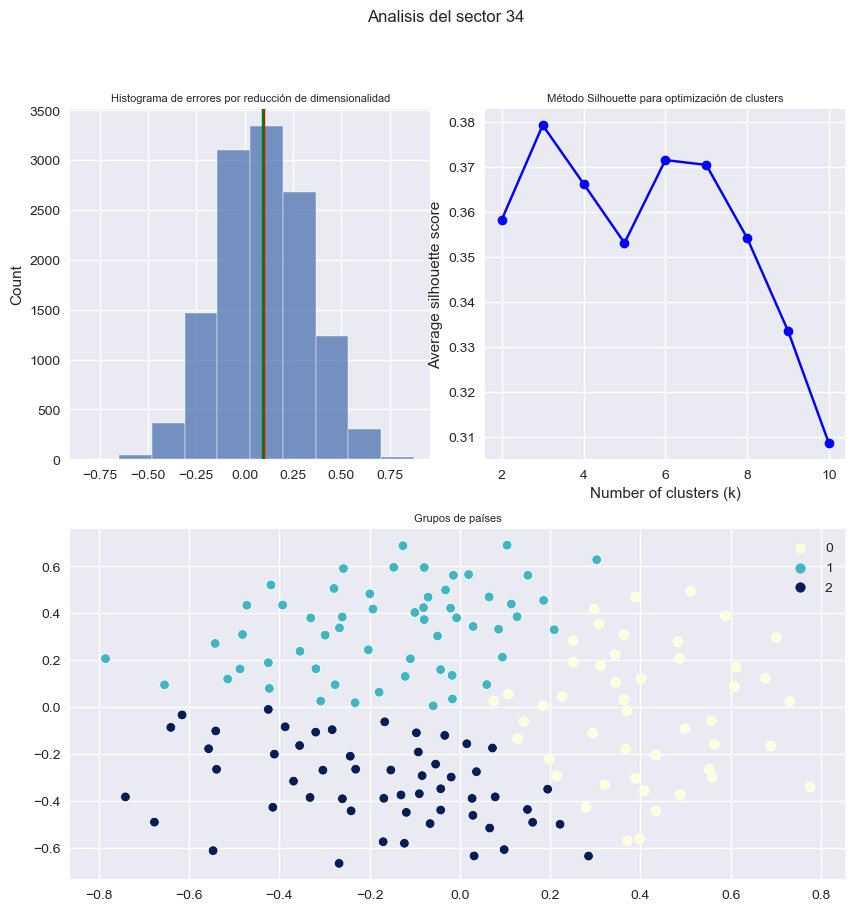

Análisis del sector 35:
R2: -3.9498076456546602
root stress: 0.39333783720197635
mean stress: 0.09587193177306425
Varianza del desvio del error: 0.08141872225113203


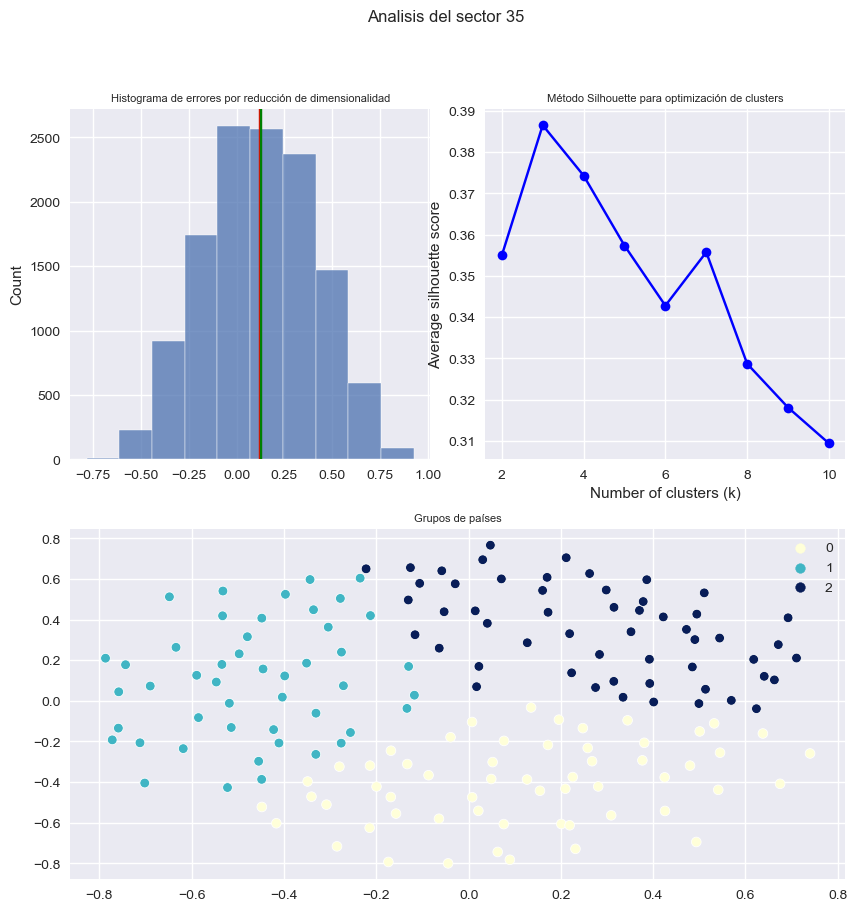

Análisis del sector 36:
R2: -2.9561776574098495
root stress: 0.3768053225648734
mean stress: 0.08858966552685454
Varianza del desvio del error: 0.07519421581726993


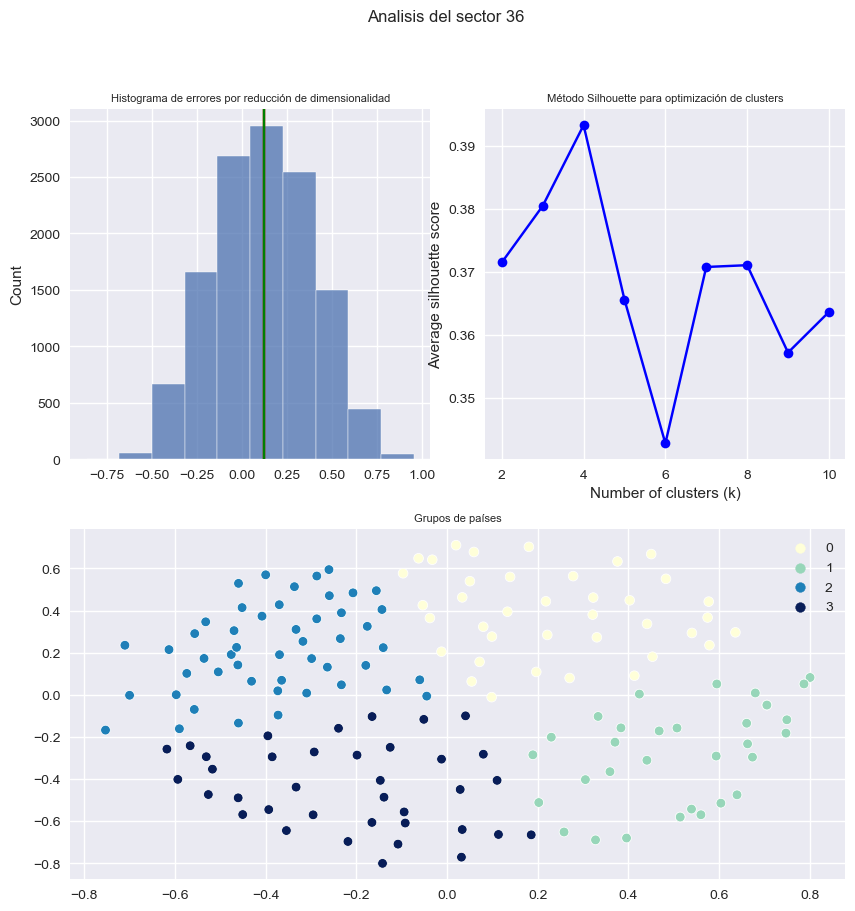

In [29]:
sectores=sorted(list(raw_data.ISIC3_2d.drop_duplicates()))[:30]

df_ciiu_country_cluster = pd.DataFrame()
for ciiu in sectores:
    #layout
    plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 10)
    gs.update(wspace=2)
    ax1 = plt.subplot(gs[0, :5], )
    ax2 = plt.subplot(gs[0, 5:])
    ax3 = plt.subplot(gs[1, :])
    print(f'Análisis del sector {ciiu}:')

    #recorte sector
    sector_binary = recorte_sectorial(ciiu)

    #calculo distancia
    dist_matrix = distancia(sector_binary)

    #reducción de dimensionalidad
    plt.sca(ax1)
    embedding = dimensionality_reduction(dist_matrix)
    plt.title('Histograma de errores por reducción de dimensionalidad', fontsize=8)
    #clusters
    plt.sca(ax2)
    clusters = k_means(embedding)
    plt.title('Método Silhouette para optimización de clusters', fontsize=8)
    #plot
    plt.sca(ax3)
    plot_clusters(embedding, clusters)
    plt.title(f'Grupos de países', fontsize=8)
    plt.suptitle(f'Analisis del sector {ciiu}')
    plt.tight_layout()
    plt.show()

    dic = {'sector': [ciiu for i in range(len(dist_matrix.index))],
       'country': list(dist_matrix.index),
       'cluster': clusters}

    dic = pd.DataFrame.from_dict(dic)

    df_ciiu_country_cluster = pd.concat([df_ciiu_country_cluster, dic])



In [30]:
df_ciiu_country_cluster.to_csv('ciiu_country_cluster.csv', index= False, sep=';')